In [7]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit
import scipy as sp
from itertools import combinations
from scipy.spatial.distance import cdist

import os


import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from jax.scipy.special import expit, logsumexp
from functools import partial
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
# import pymc_experimental as pmx

import multiprocessing
import socket
from hsgb.approximation import hsgp_squared_exponential


print(f"Running on PyMC v{pm.__version__}")
# print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


Running on PyMC v5.15.1
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [8]:
# Set CPU for JAX
# nchains = multiprocessing.cpu_count()/2
# print("nchains in total are", nchains*2, "; we'll use ", nchains)


# jax.config.update('jax_platform_name', 'cpu')
# platform = jax.lib.xla_bridge.get_backend().platform.casefold()
# print("Platform: ", platform)
# host_name = socket.gethostname()
# localhost_ = socket.gethostbyname(host_name)
# print(localhost_)

# jax.distributed.initialize(coordinator_address="localhost", num_processes=4, process_id=1)
# print(jax.device_count())
# print(jax.local_device_count())

# set_host_device_count(nchains)
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))




[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [9]:
RANDOM_SEED = 892357143
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

(array([1.3632e+04, 1.1625e+04, 8.6880e+03, 5.4650e+03, 3.1560e+03,
        1.4630e+03, 5.9200e+02, 1.7700e+02, 4.7000e+01, 5.0000e+00]),
 array([1.68074152e-04, 1.52644491e+00, 3.05272175e+00, 4.57899859e+00,
        6.10527543e+00, 7.63155226e+00, 9.15782910e+00, 1.06841059e+01,
        1.22103828e+01, 1.37366596e+01, 1.52629365e+01]),
 <BarContainer object of 10 artists>)

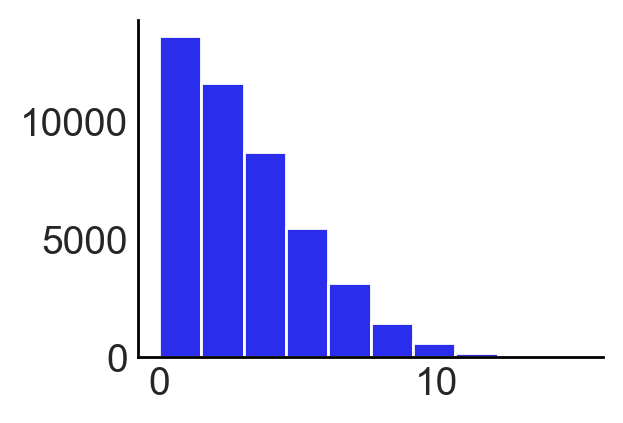

In [10]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
# x = rng.uniform(size=n,low=-3,high=3)
# x = rng.standard_t(size=n,df=5)
# x2 = rng.binomial(n=1,p=0.25,size=n)

# x_diff = []
# # x2_equal =[]
# for i in range(n):
#     for j in range(i+1,n):
#         x_diff.append(np.abs(x[i]-x[j]))
#         # x2_equal.append(x2[i]==x2[j])
# x_diff = np.array(x_diff)
# x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5

idx_pairs = combinations(range(len(x)),2)
x_diff = np.array([abs(x[i] - x[j]) for i, j in idx_pairs])


plt.figure(figsize=(3,2))
plt.hist(x_diff)


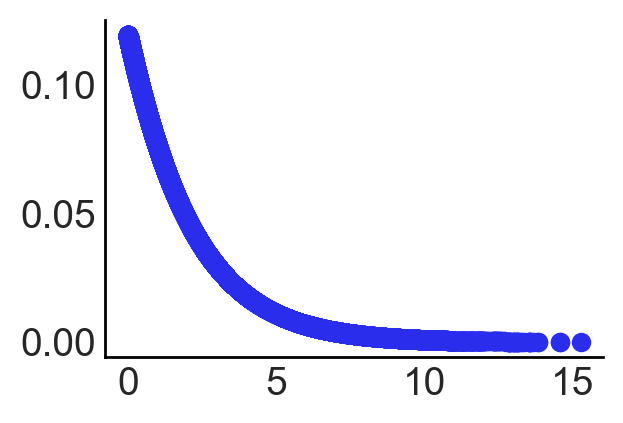

In [11]:
beta = -2, -0.5
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
probs = expit(beta[0] + beta[1]*x_diff)

plt.figure(figsize=(3,2))
plt.scatter(x_diff,probs)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]





In [12]:
def eigen_centrality(adj_mat):
    sparse_mat = sp.sparse.csr_matrix(adj_mat)
    _, eig_vec = sp.sparse.linalg.eigs(sparse_mat, k=1, which = 'LR')
    largest_v = eig_vec.flatten().real
    norm = np.sign(largest_v.sum()) * sp.linalg.norm(largest_v)
    return largest_v / norm



(array([19., 19., 26., 49., 59., 54., 35., 17., 17.,  5.]),
 array([0.00111739, 0.01233845, 0.02355951, 0.03478057, 0.04600163,
        0.05722269, 0.06844375, 0.07966481, 0.09088587, 0.10210693,
        0.11332799]),
 <BarContainer object of 10 artists>)

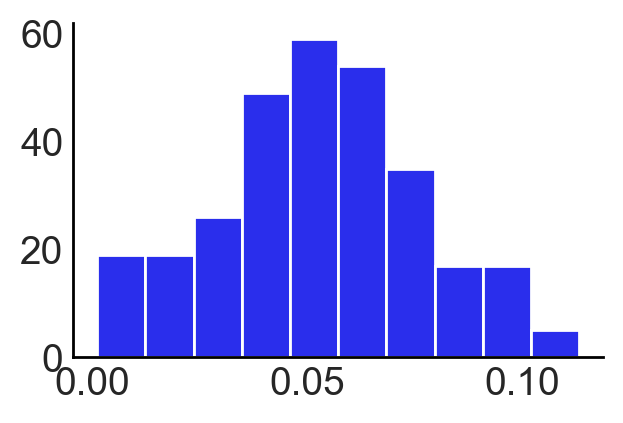

In [13]:
eigen_center = eigen_centrality(mat)
plt.figure(figsize=(3,2))
plt.hist(eigen_center)


In [14]:
# mat_net = nx.from_numpy_array(mat)
# 
# degrees = np.array([degree for _, degree in mat_net.degree()])
# deg_center = np.array(list(nx.degree_centrality(mat_net).values()))
# eigen_center = np.array(list(nx.eigenvector_centrality_numpy(mat_net).values()))
# closeness = np.array(list(nx.closeness_centrality(mat_net).values()))
# betweeness = np.array(list(nx.betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.current_flow_betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.approximate_current_flow_betweenness_centrality(mat_net,epsilon=0.1).values()))
# triangles = np.array(list(nx.triangles(mat_net).values()))
# clustering = np.array(list(nx.clustering(mat_net).values()))


In [15]:
# plt.figure(figsize=(5,3))
# np.array(list(eigen_center)).shape
# plt.hist(degrees)
# plt.hist(triangles)
# plt.hist(clustering)
# plt.hist(closeness)
# plt.hist(flow_betweeness)
# plt.hist(betweeness)
# plt.hist(closeness*triangles)
# plt.scatter(deg_center,degrees)
# plt.scatter(degrees,closeness)
# plt.scatter(betweeness,closeness)
# plt.scatter(betweeness,flow_betweeness)
# plt.scatter(triangles,flow_betweeness)
# plt.scatter(app_flow_betweeness,flow_betweeness)
# plt.scatter(triangles,closeness)
# plt.scatter(triangles,betweeness)
# plt.scatter(betweeness,degrees)
# plt.scatter(betweeness,triangles)
# plt.scatter(triangles,degrees)
# plt.scatter(triangles,betweeness)
# plt.scatter(triangles,eigen_center)
# plt.scatter(manual_eig_center,eigen_center)

In [16]:
# print(min(betweeness),max(betweeness))
# print(min(eigen_center),max(eigen_center))
# print(min(triangles),max(triangles))


           zeigen       expos    exposinv
count  300.000000  300.000000  300.000000
mean     0.242005    0.307272   57.056667
std      0.156462    0.153598   34.790728
min      0.000000    0.000000    0.000000
25%      0.122793    0.214286   31.000000
50%      0.224863    0.297059   55.500000
75%      0.353850    0.391667   81.000000
max      0.703032    1.000000  153.000000
[[1.        0.5202921]
 [0.5202921 1.       ]]


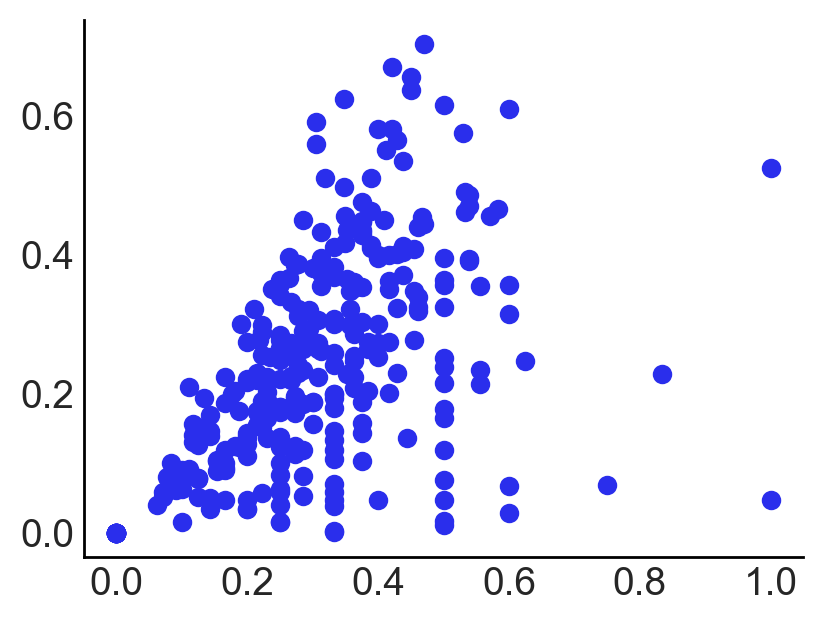

In [17]:
# Create outcome data

Z = rng.binomial(n=1,p=0.3,size=n)
degrees = np.sum(mat,1)
exposures = np.dot(mat,Z) / degrees
exposures_inv_deg = np.dot(mat,Z*degrees)
# print(pd.DataFrame(exposures).describe())
# x_neighbors = np.dot(mat,x) / degrees
# print(pd.DataFrame(x_neighbors).describe())
# print(pd.DataFrame(x).describe())

Zeigen = np.dot(mat, Z*eigen_center)
print(pd.DataFrame({"zeigen": Zeigen,"expos" : exposures, "exposinv":exposures_inv_deg}).describe())
print(np.corrcoef(Zeigen,exposures))
# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))

plt.figure(figsize=(4,3))
plt.scatter(exposures, Zeigen)
# plt.scatter(exposures_inv_deg, exposures)

(array([ 2., 10., 33., 53., 77., 56., 38., 26.,  4.,  1.]),
 array([-4.75421705, -3.63522069, -2.51622433, -1.39722797, -0.27823162,
         0.84076474,  1.9597611 ,  3.07875746,  4.19775382,  5.31675018,
         6.43574654]),
 <BarContainer object of 10 artists>)

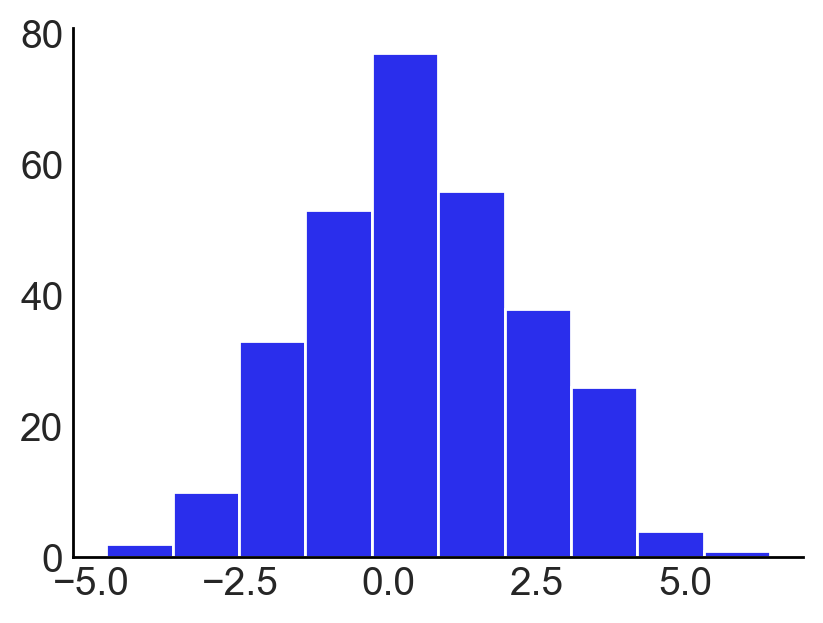

In [18]:
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
# alpha = -1, 3, 2, -.25, 5, 5 
# alpha = -1, 3, -.25, 2.5, 2 
alpha = -1, 3, -.25, 2.5 

# df_array = np.transpose(np.array([[1]*n,Z,exposures,x,eigen_center,betweeness]))
# df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen,exposures]))
df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen]))
mean_y = np.dot(df_array,alpha)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + alpha[4] + rng.normal(loc=0,scale=1,size=n)
Y = mean_y + rng.normal(loc=0,scale=1,size=n)

plt.figure(figsize=(4,3))
plt.hist(Y)


[[1.         0.73114682]
 [0.73114682 1.        ]]


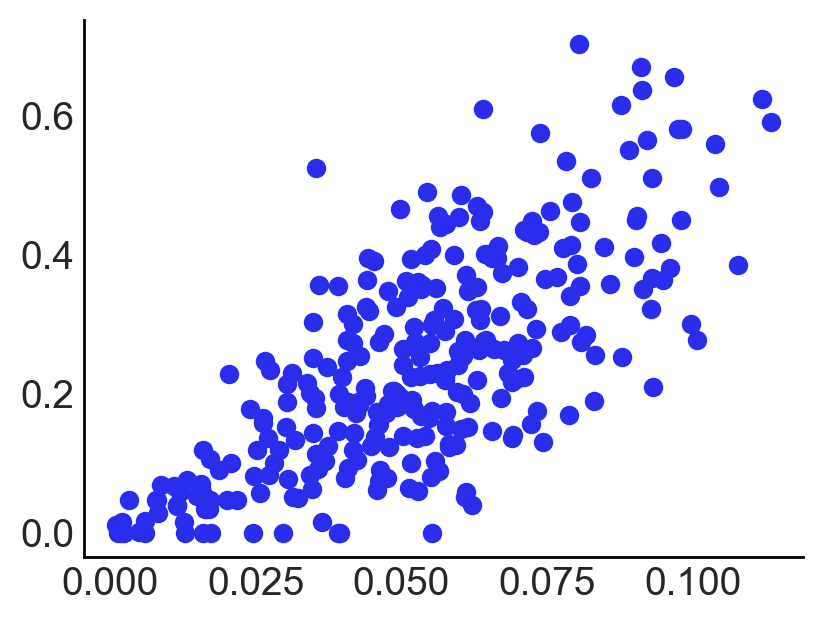

In [19]:
plt.figure(figsize=(4,3))
# plt.scatter(exposures,betweeness)
# plt.scatter(exposures,eigen_center)

print(np.corrcoef(eigen_center,Zeigen))
plt.scatter(eigen_center,Zeigen)
# plt.scatter(exposures,Zeigen)
# plt.scatter(exposures/degrees,Zeigen)
# plt.scatter(betweeness,eigen_center)
# plt.hist(Zeigen)
# plt.hist(exposures/degrees)

In [20]:
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# nx.draw(DG, with_labels=True,  node_color = Z)
# plt.legend()
# plt.show()

In [21]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
gamma0 = 0.05 # add non-existing edge with prob `bet` 

obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
for i in range(0,n): # add noise
    for j in range(i+1,n):
        if mat[i,j] == 1:
            obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
        else:
            obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
            
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


(array([ 8., 12., 40., 35., 36., 70., 50., 32., 12.,  5.]),
 array([12. , 14.4, 16.8, 19.2, 21.6, 24. , 26.4, 28.8, 31.2, 33.6, 36. ]),
 <BarContainer object of 10 artists>)

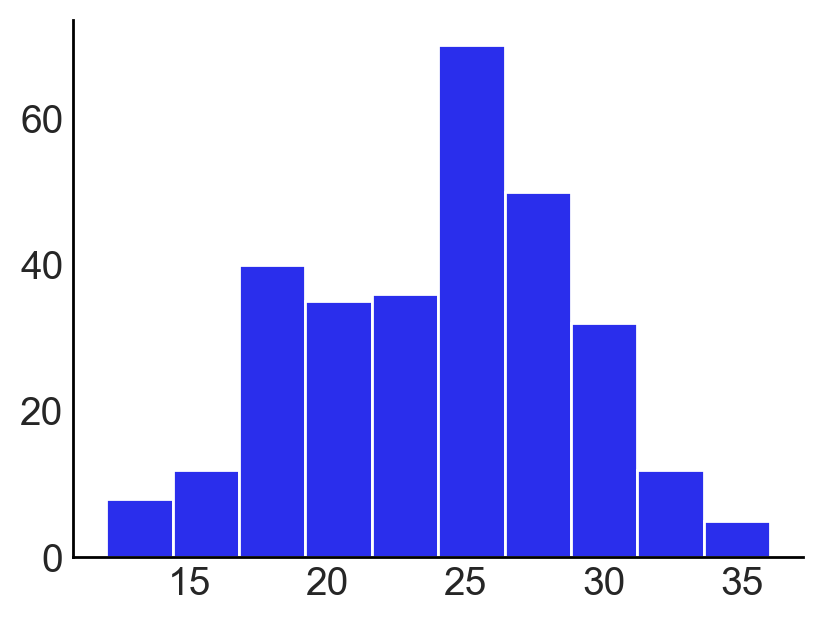

In [22]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.figure(figsize=(4,3))
plt.hist(np.sum(obs_mat,1))

In [23]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs'])


obs,0.0,1.0
true,,
0.0,40784,2157
1.0,467,1442


                0
count  300.000000
mean     0.305400
std      0.098219
min      0.047619
25%      0.238095
50%      0.309019
75%      0.368421
max      0.600000
Corr obs~true exposures:  0.5082920580832014
Corr obs~true Zeigen:  0.60825928955871


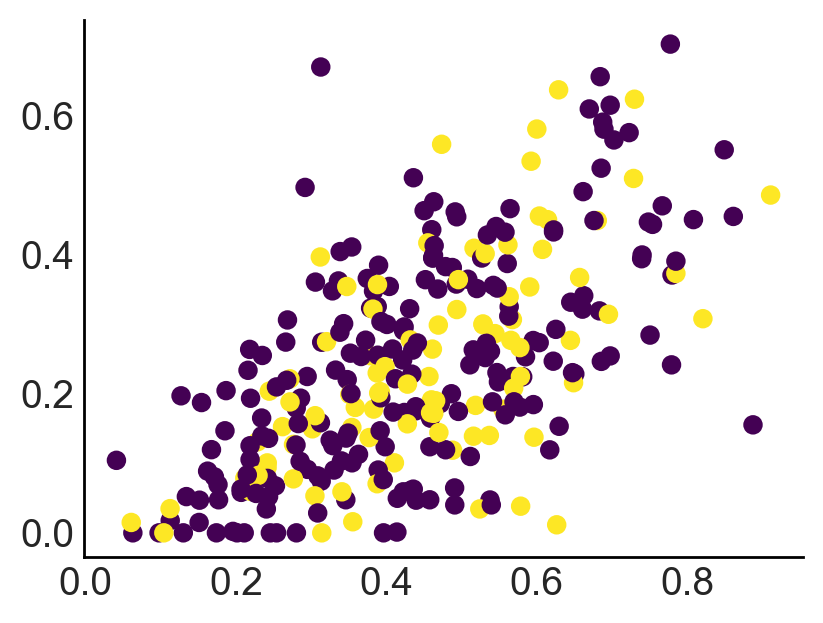

In [24]:

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)


# obs_net = nx.from_numpy_array(obs_mat)
# obs_deg = np.array([degree for _, degree in obs_net.degree()])
# obs_betweeness = np.array(list(nx.betweenness_centrality(obs_net).values()))
# obs_triangles = np.array(list(nx.triangles(obs_net).values()))
# obs_eigen_center = np.array(list(nx.eigenvector_centrality_numpy(obs_net).values()))
obs_degrees = np.sum(obs_mat,1)
obs_eigen_cent = eigen_centrality(obs_mat)
obs_exposures = np.dot(obs_mat,Z) / obs_degrees
obs_Zeigen = np.dot(obs_mat, Z*obs_eigen_cent)

# obs_df = np.transpose(np.array([[1]*n, Z, obs_exposures,x, obs_eigen_center, obs_betweeness]))
# obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen, obs_exposures]))
obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen]))

print(pd.DataFrame(obs_exposures).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])
print("Corr obs~true Zeigen: ", np.corrcoef(Zeigen, obs_Zeigen)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
plt.figure(figsize=(4,3))
# plt.scatter(obs_exposures,exposures, c=Z)
plt.scatter(obs_Zeigen,Zeigen, c=Z)

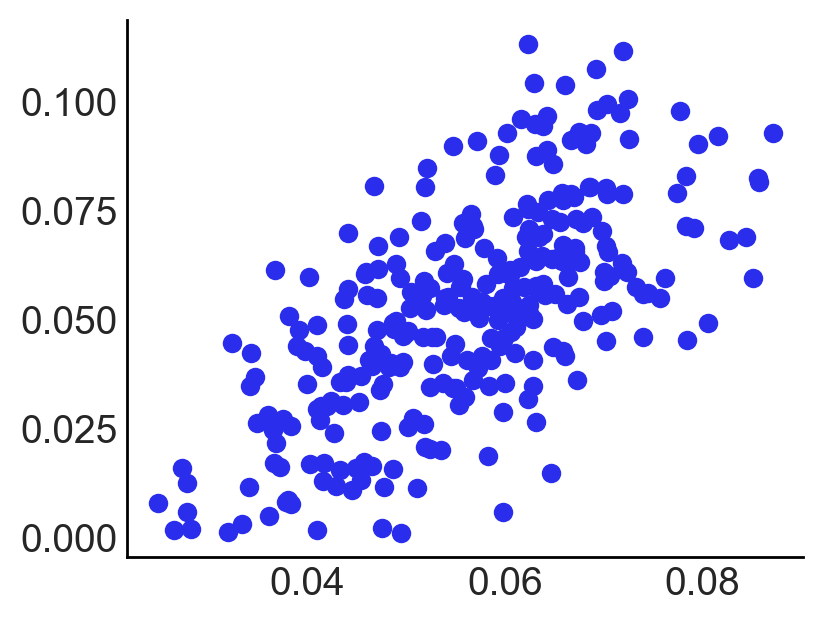

In [25]:
plt.figure(figsize=(4,3))
# plt.scatter(obs_betweeness, betweeness)
plt.scatter(obs_eigen_cent, eigen_center)

In [26]:
# with pm.Model() as model_obs_mat:
#       # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     # obs_tril = pm.ConstantData("obs_tril", tril_obs)
#     obs_triu = pm.ConstantData("obs_triu", triu_obs)
#     expos = pm.ConstantData("expos", obs_exposures)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob, observed=obs_triu)
#     # tril = pm.Bernoulli("tril", p=prob, observed=obs_tril)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     mu_y = alpha0 + alpha1*z + alpha2*expos +  alpha3*z*expos 
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#       
# pm.model_to_graphviz(model_obs_mat)

In [27]:
# def triu_vals_to_mat(triu_vals, n):
#     # Z_val = Z.eval()
#     triu_vals_ = triu_vals.eval()
#     AM = np.zeros((n,n))
#     AM[np.triu_indices(n=n,k=1)] = triu_vals_
#     # AM[np.tril_indices(n=n,k=-1)] = tril_vals_
#     # AM = AM + AM.T 
#     return AM + AM.T 
#     # return np.dot(AM,Z_val)/np.sum(AM,1)
#     
# # def get_network_miss_prob(tril_vals, gamma0, gamma1):
# #     tril_vals = tril_vals.eval()
# #     obs_tril_prob = 
# 
# with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
#     
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     obs_triu = pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)
#     
#     # Generate net stats
#     A_mat = triu_vals_to_mat(triu,n)
#     expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     deg = pm.Deterministic("deg", pm.math.sum(A_mat,1))
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=5)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=5)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=5)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     sig_y = pm.Exponential("sig_y",lam=.5)
#     mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*deg
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# pm.model_to_graphviz(model)    

In [28]:
# with model:
#     step1 = pm.Metropolis([beta0, beta1, Gamma0, Gamma1, alpha0, alpha1, alpha2, alpha3, sig_y])
#     step2 = pm.BinaryMetropolis([triu])
#     MH_step = pm.CompoundStep([step2, step1])
#     trace = pm.sample(draws=5000, tune=3000, chains=4, cores=4, step=MH_step)
#     # trace = pm.sample(draws=4000, tune=2000, chains=4, cores=4)
#     

In [29]:
# az.summary(trace)

In [30]:
# az.plot_trace(trace)


In [31]:
# with pmx.MarginalModel() as marg_model:      
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     # z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     # y = pm.ConstantData("Y_",Y)
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)  
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)   
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)    
#     # logit model of edges
#     # mu = beta0 + beta1*x + u 
#     # prob = pm.math.invlogit(mu)
#     # Ltri_A_mat = pm.Bernoulli("
#     
#     # Get exposures
#     # expos = tril_vals_to_exposures(obs_tril, z, n)
#     # Lower tri to adj. matrix
#     # A_mat = tril_vals_to_mat(obs_tril,n)
#     # A_mat = triu_vals_to_mat(triu,n)
#     # degress = pm.math.sum(A_mat,1)
#     # sum_expos = pm.math.dot(A_mat,z)
#     # expos = pm.Deterministic("expos", pm.math.switch(pt.tensor.eq(degress,0),0,sum_expos/degress))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z)/pm.math.sum(A_mat,1))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     # # Outcome model
#     # alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     # alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     # alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     # alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     # # alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     # sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*(expos**2)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*z*expos 
#     # Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# marg_model.marginalize(["triu"])
# pm.model_to_graphviz(marg_model)    

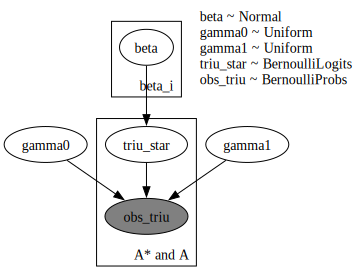

In [32]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_utri = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_utri].set(triu) 
    return adj_mat + adj_mat.T

@config_enumerate
def network_model(X, TriU, n):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,10))
    mu_net = beta[0] + beta[1]*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", triu_n):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


# def outcome_model(Y,Z,X,A,n):
def outcome_model(Y,X):
    with numpyro.plate("alpha_i",X.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    # expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    mu_y = jnp.dot(X, alpha)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff,triu_obs,n), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))

In [33]:

# squared exponential kernel with diagonal noise term
def rbf_kernel(X, Xs, var, length, noise, jitter=1.0e-6, include_noise=False):
    delta_sq =  jnp.power(cdist(X, Xs, metric="euclidean") / length, 2.0)
    k = var * jnp.exp(-0.5 * delta_sq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(delta_sq.shape[0])
    return k


def GP_outcome_model(Xgp,Xlin, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    # noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.Exponential(0.5))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    K = rbf_kernel(Xgp,Xgp, var, length, noise)
    
    # Linear part
    with numpyro.plate("alpha_i",Xlin.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    mu_lin = jnp.dot(Xlin, alpha)
    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        # dist.MultivariateNormal(loc=jnp.zeros(Y.shape[0]), covariance_matrix=k),
        dist.MultivariateNormal(loc=mu_lin, covariance_matrix=K),
        obs=Y)
    
# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for Gaussian process predictions
def predict(rng_key, Xgp, Y, Xgp_test, var, length, noise, use_cholesky=True):
    # compute kernels between train and test data, etc.
    k_pp = rbf_kernel(Xgp_test, Xgp_test, var, length, noise, include_noise=True) # mXm
    k_pX = rbf_kernel(Xgp_test, Xgp, var, length, noise, include_noise=False) # mXn
    k_XX = rbf_kernel(Xgp, Xgp, var, length, noise, include_noise=True) #nXn

    # since K_xx is symmetric positive-definite, we can use the more efficient and
    # stable Cholesky decomposition instead of matrix inversion
    if use_cholesky:
        K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
        K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, k_pX.T))
        mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y))
    else:
        K_xx_inv = jnp.linalg.inv(k_XX) #nXn
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX))) #mXm 
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y)) 
        # mean += np.dot(beta[:,np.newaxis],np.transpose(Xlin_test))
        
    # mean += np.dot(beta[:,np.newaxis], np.transpose(Xlin_test[:,np.newaxis]))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, Xgp_test.shape[:1]
    )

    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise



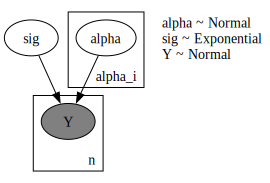

In [34]:
# numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)
numpyro.render_model(outcome_model, model_args=(Y,df_array), render_distributions=True)

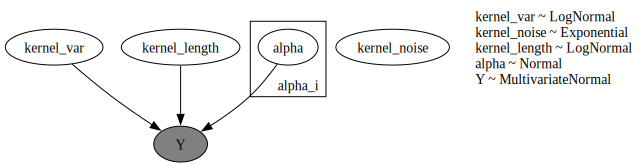

In [35]:
Xgp = df_array[:,3:]
Xlin = df_array[:,0:3]
numpyro.render_model(GP_outcome_model, model_args=(Xgp, Xlin, Y), render_distributions=True)

In [36]:
# A* and A|A* models

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model, dense_mass=True)
kernel_network = NUTS(network_model)
mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -1.90      0.26     -1.91     -2.31     -1.51   4484.94      1.00
   beta[1]     -0.58      0.07     -0.58     -0.69     -0.46   6202.34      1.00
    gamma0      0.05      0.00      0.05      0.05      0.06   6416.06      1.00
    gamma1      0.27      0.15      0.28      0.06      0.50   4580.08      1.00

Number of divergences: 0
409.787011384964


In [37]:
# Outcome model with A* (true network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.run(rng_key_,Y=Y,X=df_array)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.93      0.12     -0.92     -1.12     -0.74   9351.31      1.00
  alpha[1]      2.84      0.13      2.84      2.63      3.06  13638.51      1.00
  alpha[2]     -0.26      0.02     -0.26     -0.30     -0.23  14031.03      1.00
  alpha[3]      2.43      0.38      2.43      1.83      3.08  10100.91      1.00
       sig      1.03      0.04      1.03      0.96      1.09  13458.76      1.00

Number of divergences: 0
8.954347133636475


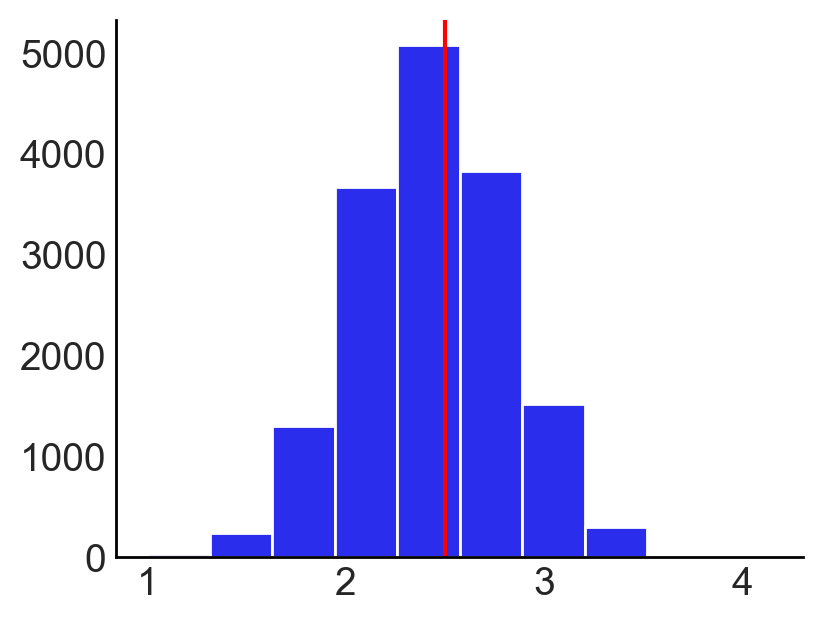

In [73]:
plt.figure(figsize=(4,3))
plt.hist(samples_net_true["alpha"][:,4])
plt.axvline(x=alpha[3], color="red")

In [39]:
# Outcome model with A (observed network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
mcmc_network_obs.run(rng_key_,Y=Y, X=obs_df)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.93      0.17     -0.93     -1.21     -0.66   8716.43      1.00
  alpha[1]      2.80      0.14      2.80      2.58      3.02  14078.99      1.00
  alpha[2]     -0.26      0.02     -0.26     -0.29     -0.22  14103.62      1.00
  alpha[3]      1.38      0.36      1.38      0.80      1.97   8865.11      1.00
       sig      1.07      0.04      1.07      1.00      1.14  15565.29      1.00

Number of divergences: 0
6.332735538482666


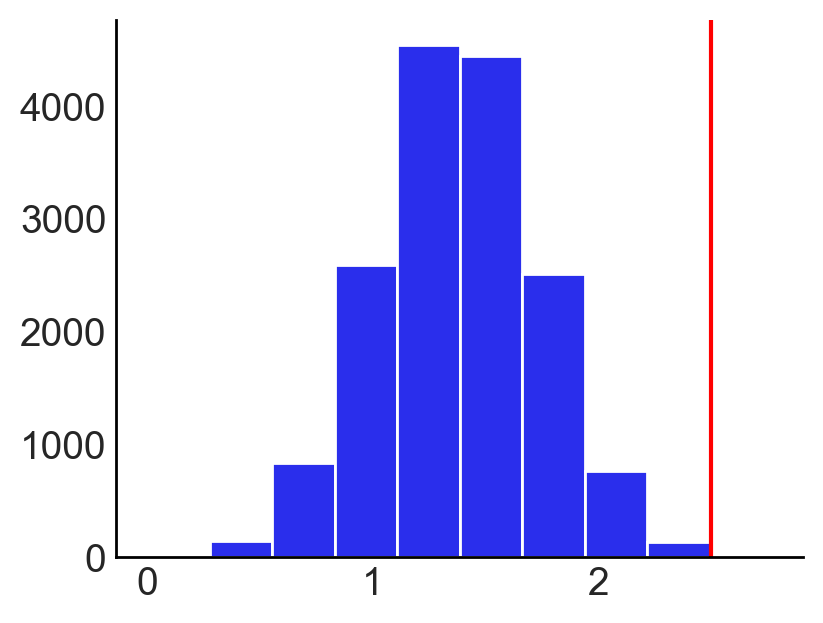

In [74]:
plt.figure(figsize=(4,3))
plt.hist(samples_net_obs["alpha"][:,4])
plt.axvline(x=alpha[3], color="red")

In [38]:
print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

['beta_0 = -2', 'beta_1 = -0.5'] gamma0: 0.05 gamma1: 0.25
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = -0.25', 'alpha_3 = 2.5'] sig: 1


In [41]:
start = time.time()
kernel_gp_outcome = NUTS(GP_outcome_model)
mcmc_GP_network_true = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_GP_network_true.run(rng_key_,Xgp=Xgp, Xlin=Xlin, Y=Y)
mcmc_GP_network_true.print_summary()
samples_GP_net_true = mcmc_GP_network_true.get_samples()
print(time.time() - start)
# TODO: BAD RESULTS! change initiation or implementations!

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha[0]     -0.68      0.99     -0.69     -1.89      0.54      2.00  37580.84
       alpha[1]      0.17      1.23      0.26     -1.36      1.52      2.00 148954.59
       alpha[2]      0.91      0.63      0.82      0.12      1.88      2.00  41402.53
  kernel_length      1.52      0.86      1.50      0.51      2.57       nan 7482853.18
   kernel_noise      3.07      2.72      2.94      0.31      6.06      2.00 5405570.78
     kernel_var      0.73      0.38      0.53      0.48      1.38       nan 2115359.32

Number of divergences: 16000
38.915085792541504


In [42]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)
a_star_pred = Predictive(model=network_model, posterior_samples=post_pred_mean, infer_discrete=True,num_samples=1)
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

(16000, 2)
(16000,)
{'beta': Array([[-1.9016219, -0.580249 ]], dtype=float32), 'gamma0': Array([0.05234896], dtype=float32), 'gamma1': Array([0.27144083], dtype=float32)}
(1, 44850)
(1, 44850)
False


sec,0,1
first,,
0,41720,1251
1,1201,678


In [43]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
post_predictive = post_predictive(rng_key, X=x_diff,TriU=triu_obs,n=n)
samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(16000, 44850)
(44850,)


In [45]:
NN = n

@jax.jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # adj_mat = np.zeros((NN,NN))
    # obs_mat[np.triu_indices(n=NN,k=1)] = triu_v
    idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T

#     AM = np.zeros((NN,NN))
#     AM[np.triu_indices(n=NN,k=1)] = triu_v
#     return AM + AM.T 
# 
# 
# print(np.triu_indices(n=NN,k=1))
# print(a_star_pred1["triu_star"].shape)
# print(a_star_pred1["triu_star"][0])
# 
# st = time.time()
# for i in range(10000):
#     A1 = triu_to_mat(a_star_pred1["triu_star"], n)
# print("Regular takes: ", time.time() - st)

st = time.time()
for i in range(100):
    A2 = Triu_to_mat(a_star_pred1["triu_star"][i])
print("jax.jit takes: ", time.time() - st)

# np.array(Triu_to_mat(a_star_pred1["triu_star"][0])).shape

# print(np.array_equal(A1,A2))


jax.jit takes:  0.3215067386627197


(300, 300)
True expos~Y corr: 0.6059657359900121
Pred1 expos~Y corr: 0.2723033696794489
Pred2 expos~Y corr: 0.34109431351118774
obs expos~Y corr: 0.29609561306051313


Text(0, 0.5, 'True')

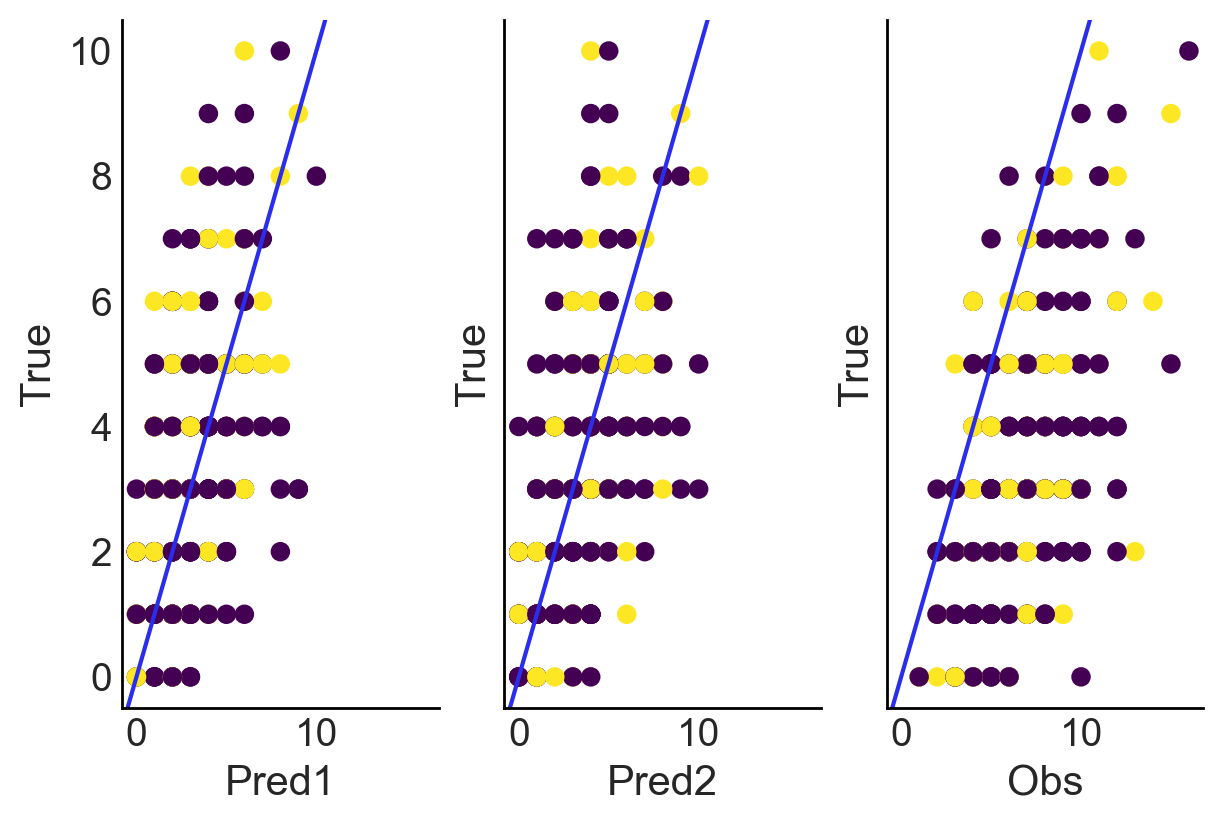

In [217]:

A_star_pred = Triu_to_mat(a_star_pred1["triu_star"][0])
A_star_pred2 = Triu_to_mat(a_star_pred2["triu_star"][0])
# A_star_pred = triu_to_mat(a_star_pred1["triu_star"],n)
# A_star_pred2 = triu_to_mat(a_star_pred2["triu_star"],n)
print(A_star_pred.shape)
# print(A_star_pred)


a_star_pred_deg = np.sum(A_star_pred,1)
a_star_pred_deg2 = np.sum(A_star_pred2,1)
a_star_sum_expos = np.dot(A_star_pred,Z) 
a_star_sum_expos2 = np.dot(A_star_pred2,Z)

Pred_expos1 = np.where(np.equal(a_star_pred_deg,0),0,a_star_sum_expos/a_star_pred_deg)
Pred_expos2 = np.where(np.equal(a_star_pred_deg2,0),0,a_star_sum_expos2/a_star_pred_deg2)

print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
print("Pred1 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos)[1,0])
print("Pred2 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos2)[1,0])
print("obs expos~Y corr:",np.corrcoef(Y,obs_exposures)[1,0])


fig, axes = plt.subplots(nrows=1,ncols=3, sharex=True, sharey=True, figsize = (6,4))
ax1, ax2, ax3 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(a_star_sum_expos, exposures,c = Z+1, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(a_star_sum_expos2, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax3.scatter(obs_exposures, exposures,c = Z+1, marker = 'o')
ax3.axline((0,0),slope=1)
ax1.set_xlabel("Pred1")
ax2.set_xlabel("Pred2")
ax3.set_xlabel("Obs")
ax1.set_ylabel("True")
ax2.set_ylabel("True")
ax3.set_ylabel("True")
# ax.axline((0,0),slope=1)
# ax.set_xlabel("Obs")
# ax.set_ylabel("True")
# plt.show()

In [267]:
# np.array(a_star_pred1["triu_star"][0]).shape
nx.from_numpy_array(Triu_to_mat(a_star_pred1["triu_star"][0]))

In [48]:
# @partial(jit, static_argnums=1)
# @jax.jit
def compute_net_stats(adj_mat, Z):
    expos = jnp.dot(adj_mat, Z)
    net = nx.from_numpy_array(adj_mat)
    eigen_cen = jnp.array(list(nx.eigenvector_centrality_numpy(net).values()))
    betweeness = jnp.array(list(nx.betweenness_centrality(net).values()))
    return expos, eigen_cen, betweeness
    
# Two-stage with mean posterior of A* and A|A* parameters
def twostage_estimator(MCMC_obj, a_star_pred, Y, Z, X, x_diff, triu_obs, n,i):
    
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=n)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
    curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
   
    # pred_exp = np.dot(curr_Astar, Z)
    # print("Pred expos~Y corr:",np.corrcoef(Y,pred_exp)[1,0])
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X, A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()
    
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
    # return xr.DataArray(converted_post_samp)


NN = n

@jax.jit
# def get_samples(key, Y, Z, X, A ,n_warmup=500, n_samples=250, n_chains=2):
def get_samples(key, Y, df, n_warmup=500, n_samples=250, n_chains=2):
    kernel_outcome = NUTS(outcome_model)
    mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False)
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    mcmc.run(key, Y=Y, X=df)
    return mcmc.get_samples()

def twostage_jj(a_star_pred, Y, Z, X, x_diff, triu_obs, i):
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=NN)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],NN)
    curr_Astar = Triu_to_mat(curr_Astar["triu_star"][0])
    # net stats
    # expos = np.dot(curr_Astar,Z)
    cur_eigen_cen = eigen_centrality(curr_Astar)
    cur_Zeigen = jnp.dot(curr_Astar,Z*cur_eigen_cen)
    # expos, eigen_cen, between = compute_net_stats(np.array(curr_Astar), Z)
    # expos, eigen_cen, between = compute_net_stats(curr_Astar, jnp.array(Z))
    # get df
    # cur_df = np.transpose(np.array([[1]*NN,Z,expos,X,eigen_cen,between]))
    cur_df = np.transpose(np.array([[1]*NN,Z,X,cur_Zeigen]))
    # Run MCMC
    # curr_posterior_samples = get_samples(random.PRNGKey(i**2), Y, Z, X, curr_Astar)
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, cur_df)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
#      
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred_jit = MCMC(kernel_outcome, num_warmup=250, num_samples=500,num_chains=1, progress_bar=False, jit_model_args=True)
# twostage_post_samp = Parallel(n_jobs=4)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n, 100))
# print("starting parallel")
# print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
# 
# # # 
# start = time.time()
# twostage_post_samp = Parallel(n_jobs=8)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x, x_diff, triu_obs, n,i) for i in tqdm(range(10)))
# # twostage_post_samp = xr.merge(twostage_post_samp)
# twostage_post_samp = pd.concat(twostage_post_samp,axis=0)
# print(twostage_post_samp)
# print("No JIT takes: ", time.time() - start)


start = time.time()
twostage_post_samp_jit = pd.DataFrame()
# for i in tqdm(range(50)):
for i in tqdm(range(500)):
    cur_res = twostage_jj(a_star_pred, Y, Z, x, x_diff, triu_obs,i)
    twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
print(twostage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)



# print(time.time() - start)
# print("starting sequential")
# start = time.time()
# twostage_post_samp2 = [twostage_estimator(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n,i) for i in tqdm(range(20))]
# twostage_post_samp2 = pd.concat(twostage_post_samp2,axis=0)
# print(time.time() - start)

# print(twostage_post_samp)
# print(twostage_post_samp.shape)
# print(twostage_post_samp2)
# print(twostage_post_samp2.shape)

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\jax\_src\interpreters\pxla.py:1797: UserWarning: The jitted function get_samples includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
100%|██████████| 500/500 [00:59<00:00,  8.34it/s]

     iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0       0  1.027637 -0.591264  2.941179 -0.241298  1.108494
1       0  1.135831 -0.834104  2.736963 -0.262440  1.844459
2       0  1.096237 -0.553085  2.755933 -0.260095  1.281372
3       0  1.034463 -0.561661  2.846413 -0.245942  1.081608
4       0  1.127189 -0.696435  3.054954 -0.270696  1.210582
..    ...       ...       ...       ...       ...       ...
495   499  1.153875 -0.858692  3.194550 -0.241027  1.674604
496   499  1.062321 -0.921088  3.328111 -0.271984  1.758588
497   499  1.067997 -0.982373  3.243180 -0.273565  1.807961
498   499  1.085574 -0.726911  2.590851 -0.223135  1.517624
499   499  1.059918 -0.748766  2.640994 -0.222149  1.744423

[250000 rows x 6 columns]
with JIT (non parallel) takes:  59.9726939201355


(250000, 6)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = -0.25', 'alpha_3 = 2.5'] sig: 1
              iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean    249.500000  1.074657 -0.639465  2.818256 -0.254340  1.308492
std     144.337567  0.045072  0.133239  0.137722  0.023087  0.476120
median  249.500000  1.073127 -0.639608  2.818235 -0.254300  1.306890
q005      2.000000  0.966995 -0.984604  2.463550 -0.313520  0.089743
q025     12.000000  0.990772 -0.901259  2.548560 -0.299758  0.379590
q975    487.000000  1.167402 -0.379054  3.088122 -0.209007  2.245986
q995    497.000000  1.199736 -0.293240  3.174852 -0.194754  2.564764
min       0.000000  0.875038 -1.252209  2.193429 -0.366450 -0.744186
max     499.000000  1.322912 -0.034468  3.419347 -0.145136  3.488070


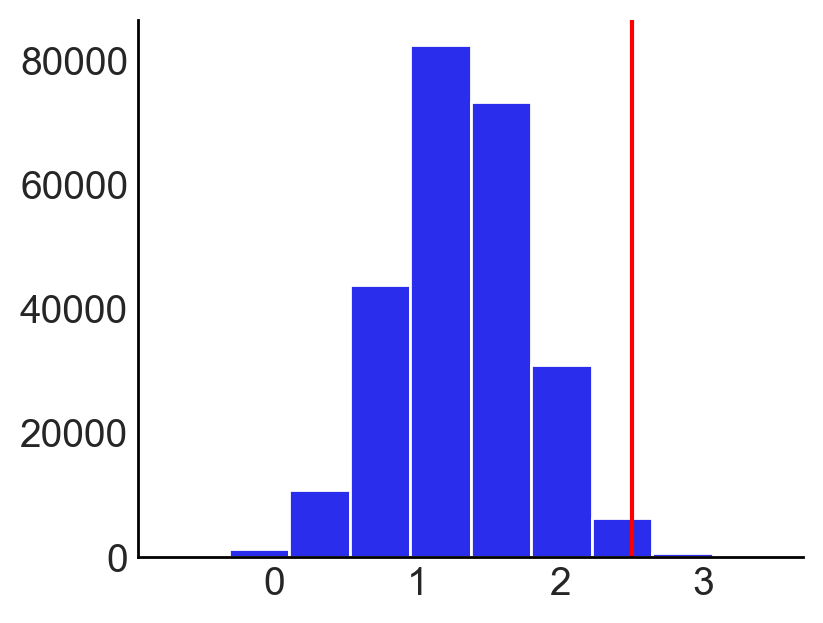

In [50]:
def q025(x):
    return x.quantile(.025)

def q975(x):
    return x.quantile(.975)

def q005(x):
    return x.quantile(.005)

def q995(x):
    return x.quantile(.995)

print(twostage_post_samp_jit.shape)
# print(twostage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:",1)
print(twostage_post_samp_jit.agg(['mean','std','median',q005,q025, q975, q995,'min','max']))

plt.figure(figsize=(4,3))
plt.hist(twostage_post_samp_jit["alpha_3"])
plt.axvline(x=alpha[3], color="red")
# plt.scatter(twostage_post_samp["alpha_2"],twostage_post_samp["alpha_3"])

# TODO: check what is going on in here... we obtain weird results for alpha_2

In [51]:
# Three-stage: for each A* and A|A* param, sample one A*, and sample one (or more) outcome models
def threestage_estimator(MCMC_obj, net_post_samples, Y, Z, X, n, i):

    # sample network
    curr_Astar = triu_to_mat(net_post_samples[i,], n)
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X,A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()

    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)


def threestage_jj(triu_post_samp, Y, Z, X, i):
    # sample network
    # curr_Astar = triu_to_mat(triu_post_samp, NN)
    curr_Astar = Triu_to_mat(triu_post_samp)
    # compute stats
      # expos = np.dot(curr_Astar,Z)
    cur_eigen_cen = eigen_centrality(curr_Astar)
    cur_Zeigen = jnp.dot(curr_Astar,Z*cur_eigen_cen)
    # expos, eigen_cen, between = compute_net_stats(np.array(curr_Astar), Z)
    # expos, eigen_cen, between = compute_net_stats(curr_Astar, jnp.array(Z))
    # get df
    # cur_df = np.transpose(np.array([[1]*NN,Z,expos,X,eigen_cen,between]))
    cur_df = np.transpose(np.array([[1]*NN,Z,X,cur_Zeigen]))
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, cur_df)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
#      
# kernel_outcome = NUTS(outcome_model)
# # mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=1000, num_samples=100,num_chains=2, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 3000)

# print("starting parallel")
# start = time.time()
# threestage_post_samp = Parallel(n_jobs=8)(delayed(threestage_estimator)(mcmc_network_pred, post_predictive["triu_star"], Y, Z,x, n,i) for i in tqdm(i_range))
# threestage_post_samp = pd.concat(threestage_post_samp,axis=0)
# print(threestage_post_samp)
# print("No JIT time: ", time.time() - start)


K = 500
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
start = time.time()
threestage_post_samp_jit = pd.DataFrame()
for i in tqdm(i_range):
# for i in tqdm(range(Astar_post_shape[0])):
# for i in tqdm(range(Astar_post_shape[0])):
    cur_res = threestage_jj(post_predictive["triu_star"][i,], Y, Z, x, i)
    threestage_post_samp_jit = pd.concat([threestage_post_samp_jit, cur_res])    
print(threestage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)




100%|██████████| 500/500 [00:24<00:00, 20.82it/s]

     iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0     914  1.064149 -0.734437  2.835428 -0.194442  1.559424
1     914  1.058778 -0.652462  2.816849 -0.307502  1.568177
2     914  1.105411 -0.705082  2.714321 -0.216615  1.662158
3     914  1.088065 -0.704426  2.804991 -0.231133  1.739526
4     914  1.035103 -0.662789  2.851263 -0.280673  1.313125
..    ...       ...       ...       ...       ...       ...
495  1361  1.067199 -0.756067  2.629740 -0.251599  1.369006
496  1361  1.120281 -0.657863  3.049759 -0.269390  1.171558
497  1361  1.025474 -0.784211  2.850960 -0.251579  1.030549
498  1361  1.032477 -0.710058  2.852289 -0.247183  1.252867
499  1361  1.018675 -0.731512  2.803683 -0.249341  1.325305

[250000 rows x 6 columns]
with JIT (non parallel) takes:  24.036579370498657


(250000, 6)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = -0.25', 'alpha_3 = 2.5'] sig: 1
                iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean     8374.198000  1.074332 -0.644725  2.820249 -0.254125  1.324065
std      4618.331305  0.045026  0.137757  0.136765  0.023123  0.519818
median   8533.500000  1.072809 -0.642959  2.820477 -0.254144  1.297109
q005       58.000000  0.966742 -1.013691  2.466783 -0.313809  0.094787
q025      355.000000  0.990356 -0.920349  2.552574 -0.299425  0.376882
q975    15733.000000  1.166682 -0.379942  3.087698 -0.208824  2.418839
q995    15969.000000  1.198707 -0.298807  3.173307 -0.194431  2.808106
min        22.000000  0.879277 -1.329109  2.166928 -0.359391 -0.767010
max     15990.000000  1.303183 -0.061919  3.425631 -0.150187  4.345049


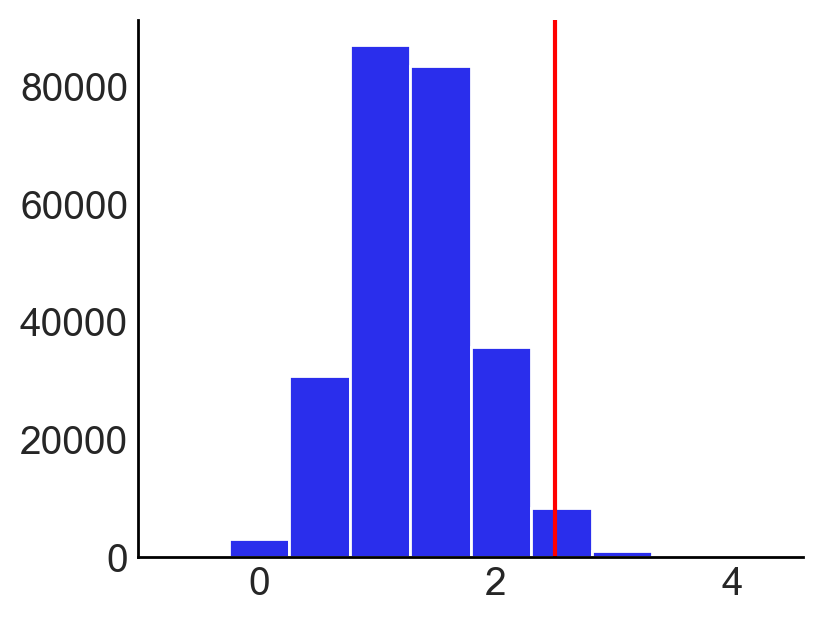

In [53]:
print(threestage_post_samp_jit.shape)
# print(threestage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:", 1)
threestage_post_samp_agg = threestage_post_samp_jit.agg(['mean','std','median',q005,q025, q975,q995,'min','max'])
print(threestage_post_samp_agg)

plt.figure(figsize=(4,3))
plt.hist(threestage_post_samp_jit["alpha_3"])
plt.axvline(x=alpha[3], color="red")

In [54]:
print(threestage_post_samp_agg["alpha_2"]["mean"])
dict_3S = threestage_post_samp_agg["alpha_2"].to_dict()
print(dict_3S)
dict_3S["var_MI"] = 3
print(dict_3S)
dict_3S = {k : dict_3S[k] for k in ["mean","median","var_MI","q025","q975","min","max"]}
print(pd.DataFrame(dict_3S, index = [0]))


-0.2541254758834839
{'mean': -0.2541254758834839, 'std': 0.0231234822422266, 'median': -0.2541444003582001, 'q005': -0.31380895256996155, 'q025': -0.299424696713686, 'q975': -0.2088236715644598, 'q995': -0.1944307367503643, 'min': -0.359390527009964, 'max': -0.15018680691719055}
{'mean': -0.2541254758834839, 'std': 0.0231234822422266, 'median': -0.2541444003582001, 'q005': -0.31380895256996155, 'q025': -0.299424696713686, 'q975': -0.2088236715644598, 'q995': -0.1944307367503643, 'min': -0.359390527009964, 'max': -0.15018680691719055, 'var_MI': 3}
       mean    median  var_MI      q025      q975       min       max
0 -0.254125 -0.254144       3 -0.299425 -0.208824 -0.359391 -0.150187


In [55]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



VB:  1.639853379052722e-05 VW:  0.00051936624  Total var:  0.0005357975672616928  Naive var:  0.0005346933


In [57]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).

def onestage_estimator(net_post_samples, Z, n, i_range):
    
    deg_list = []
    # sum_expos_list = []
    expos_list = []
    eig_cen_list = []
    Zeigen_list = []
    
    for i in i_range:
        # sample network
        # curr_Astar = triu_to_mat(net_post_samples[i,], n)
        curr_Astar = Triu_to_mat(net_post_samples[i,])
        # compute stat
        # expos, eig_cen, between = compute_net_stats(curr_Astar, Z)
        
        # save statistics
        # c_deg = np.sum(curr_Astar,1)
        # c_sum_expos = np.dot(curr_Astar, Z)
        # c_expos = np.where(np.equal(c_deg,0),0,c_sum_expos/c_deg)
        
        deg_list.append([jnp.sum(curr_Astar,1)])
        expos_list.append([jnp.dot(curr_Astar, Z)])
        
        cur_eig_cen = eigen_centrality(curr_Astar)
        eig_cen_list.append([cur_eig_cen])
        Zeigen_list.append([jnp.dot(curr_Astar, Z*cur_eig_cen)])
        
               
        # deg_list.append([c_deg])
        # sum_expos_list.append([c_sum_expos])
        # expos_list.append([c_expos])
        if i == max(i_range)//2:
            print("mid way")
    
    return {'deg' : deg_list,
            # 'sum_expos' : sum_expos_list,
            'expos' : expos_list,
            'eig_cen' : eig_cen_list,
            'Zeigen' : Zeigen_list}
        
# i_range = np.random.randint(low=0, high=post_predictive["triu_star"].shape[0],size =5000)
start = time.time()
onestage_net_stat = onestage_estimator(post_predictive["triu_star"], Z, n, range(post_predictive["triu_star"].shape[0]))
print(time.time() - start)
# onestage_net_stat = Parallel(n_jobs=8)(delayed(onestage_estimator)(post_predictive["triu_star"], Z, n,i) for i in tqdm(i_range))
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=1000,num_chains=1, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 1000)


mid way
51.217905044555664


deg corr 0.8246022627882363
expos corr 0.28970241112404405
zeigen corr 0.7133004427303671


Text(0, 0.5, 'True Zeigen')

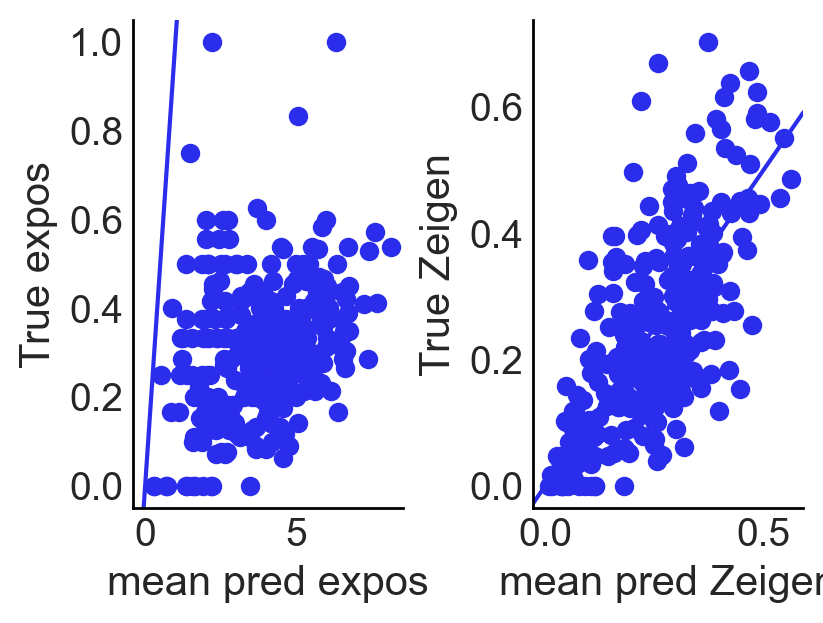

In [72]:
mean_deg = np.mean(onestage_net_stat["deg"],axis=0)
mean_expos = np.mean(onestage_net_stat["expos"],axis=0)
mean_eig_cen = np.mean(onestage_net_stat["eig_cen"],axis=0)
mean_Zeigen = np.mean(onestage_net_stat["Zeigen"],axis=0)

# mean_sum_expos = np.mean(onestage_net_stat["sum_expos"],axis=0)

print("deg corr", np.corrcoef(mean_deg,degrees)[1,0])
print("expos corr", np.corrcoef(mean_expos,exposures)[1,0])
print("zeigen corr", np.corrcoef(mean_Zeigen,Zeigen)[1,0])
# print("expos (hat) corr Y", np.corrcoef(mean_expos,Y)[1,0])
# print("expos (true) corr Y", np.corrcoef(exposures,Y)[1,0])

fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize = (4,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_deg, np.sum(mat,1), marker = 'o')
ax1.scatter(mean_expos,exposures, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(mean_Zeigen, Zeigen,)
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred expos")
ax2.set_xlabel("mean pred Zeigen")
ax1.set_ylabel("True expos")
ax2.set_ylabel("True Zeigen")


In [396]:
np.transpose(np.array(mean_Zeigen))[:,:].shape

(300, 1)

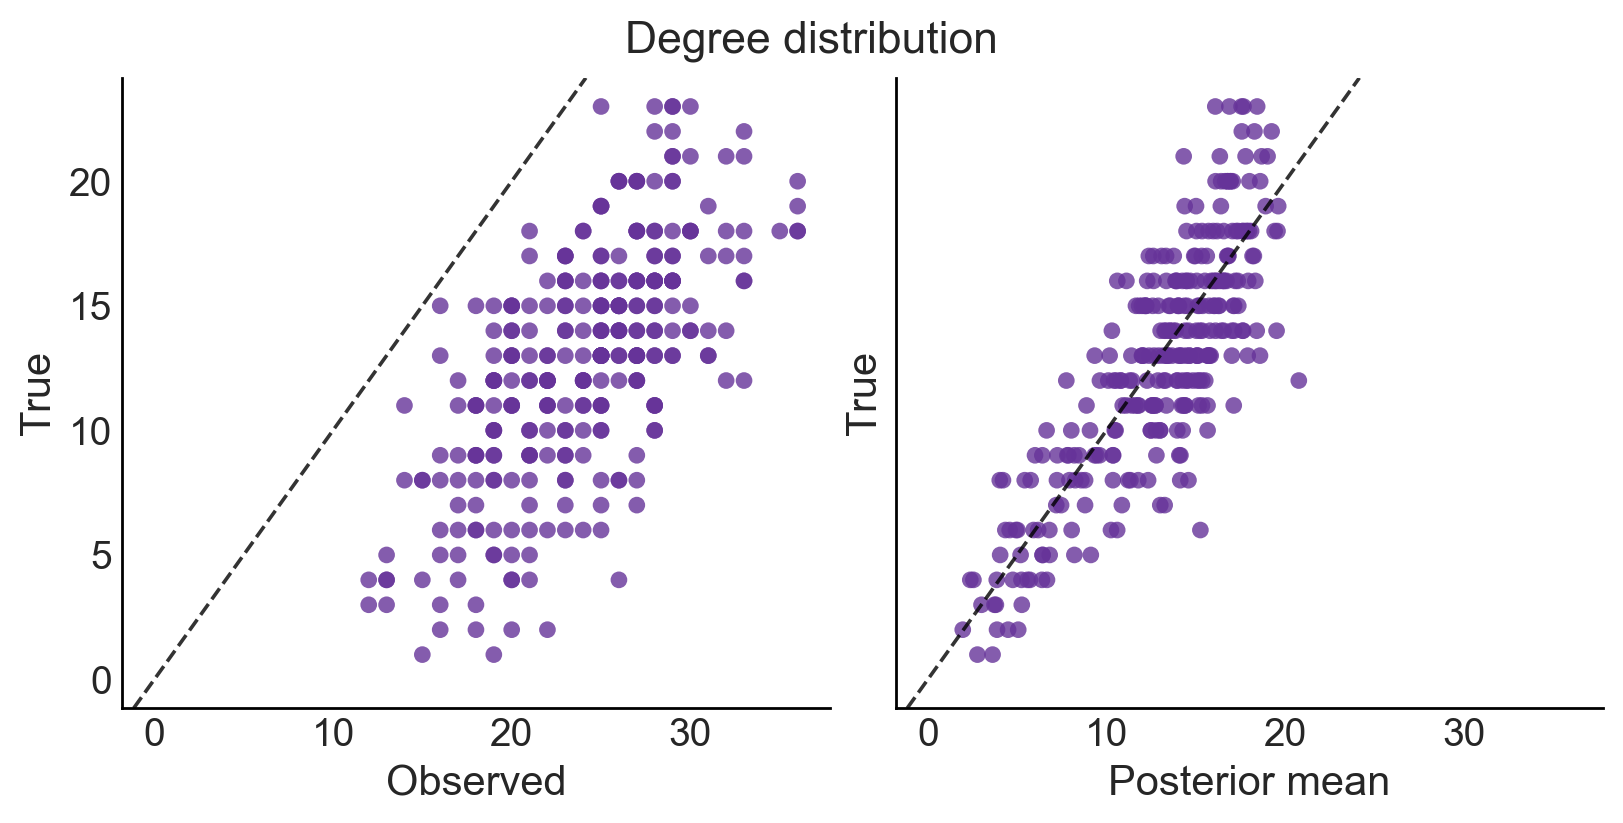

In [59]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)

Text(0, 0.5, 'True')

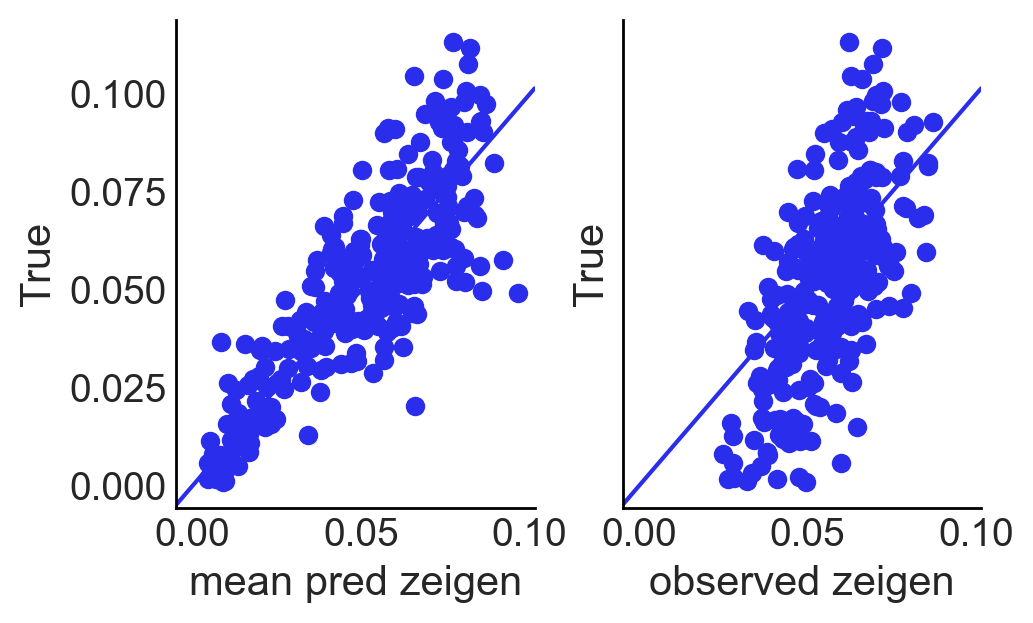

In [60]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_expos, exposures, c = Z, marker = 'o')
# ax1.scatter(mean_Zeigen, Zeigen, marker = 'o')
ax1.scatter(mean_eig_cen, eigen_center, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.scatter(obs_exposures, exposures,c = Z, marker = 'o')
ax2.scatter(obs_eigen_cent, eigen_center,marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred zeigen")
ax2.set_xlabel("observed zeigen")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

In [63]:

mean_Zeigen = np.reshape(mean_Zeigen, (300,))
one_stage_df = np.transpose(np.array([[1]*n, Z, x, mean_Zeigen]))

In [64]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
kernel_stat_outcome = NUTS(outcome_model)
mcmc_network_stat = MCMC(kernel_stat_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_stat.run(rng_key_,Y=Y,X=one_stage_df)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_stat.print_summary()
samples_network_stat = mcmc_network_stat.get_samples()
print(time.time() - start)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.89      0.14     -0.89     -1.12     -0.65  10827.60      1.00
  alpha[1]      2.81      0.13      2.81      2.60      3.03  14475.64      1.00
  alpha[2]     -0.25      0.02     -0.25     -0.28     -0.21  14426.68      1.00
  alpha[3]      2.30      0.51      2.30      1.47      3.13  11179.91      1.00
       sig      1.06      0.04      1.06      0.99      1.13  14273.52      1.00

Number of divergences: 0
9.375524997711182
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = -0.25', 'alpha_3 = 2.5'] sig: 1


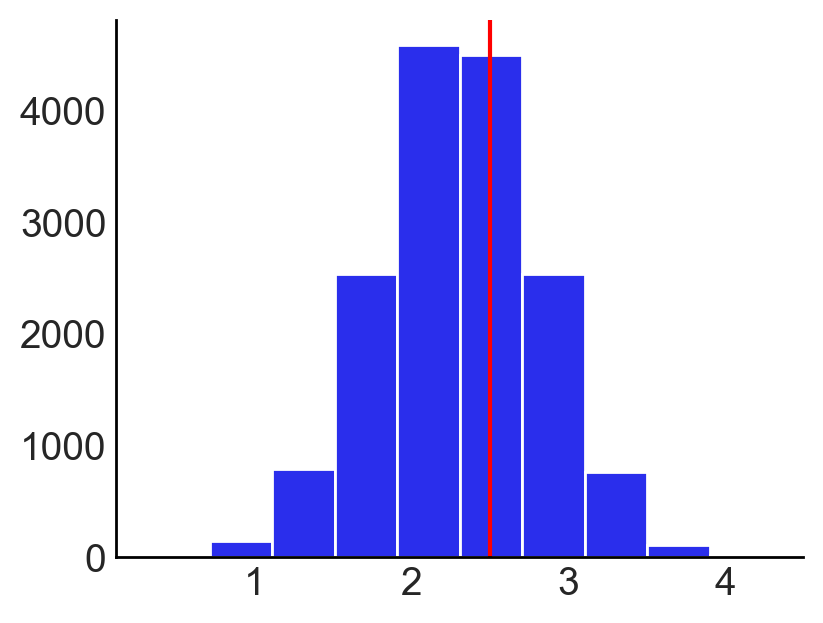

In [71]:
plt.figure(figsize=(4,3))
plt.hist(samples_network_stat["alpha"][:,4])
plt.axvline(x=alpha[3], color="red")

In [339]:
# dims = {"X": ["time"], "TriU": ["time"]}
# idata_kwargs = {"dims": dims, "constant_data": {"X": x_diff, "TriU": triu_obs}}
# trace_data = az.from_numpyro(mcmc, **idata_kwargs)
# trace_data = az.from_numpyro(posterior=mcmc_network, posterior_predictive=post_predictive,)
# display(trace_data)
# az.plot_trace(trace_data, compact=True)

In [340]:
# posterior_mu = jnp.expand_dims(samples["beta0"],-1) + jnp.expand_dims(samples["beta1"],-1)*x_diff

# print(posterior_mu.shape)
# print(posterior_mu[0:5,0:5])

# fix, ax = plt.subplots(nrows=1,ncols=1, figsize = (5,5))
# ax.plot(beta[0] + beta[1]*x_diff, posterior_mu.mean(axis=0), "o")


In [341]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_triu = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_triu].set(triu) 
    return adj_mat + adj_mat.T

def model_discrete(Y, Z, X, TriU, n):
    # Network model
    beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    mu_net = beta_0 + beta_1*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    
    # temp = numpyro.sample("temp", dist.Uniform(low=0,high=1))
    
    with numpyro.plate("A* and A",triu_n):
        # logp of A* 
        triu_star = numpyro.sample("triu_star",dist.BernoulliLogits(logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=.5,logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=temp,logits=mu_net))
        # # logp of A|A*
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = jnp.where(tril_star==1, 1-gamma1, gamma0)
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
       
    # get Astar the symmetric matrix from lower triangle values `tril_var`
    Astar = numpyro.deterministic("Astar", triu_to_mat(triu_star,n))
    # Compute exposures (Astar*Z / d)
    degrees = jnp.sum(Astar,1)
    # num_expos = jnp.dot(Astar,Z)
    # expos = numpyro.deterministic("expos", jnp.where(degress==0,0,num_expos/degrees))
    expos = numpyro.deterministic("expos", jnp.nan_to_num(jnp.dot(Astar,Z)/jnp.sum(Astar,1),nan=0.0))
       
    
    # Outcome model
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig", dist.Exponential(0.5))
    mu = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*degrees
    with numpyro.plate("n",n):
        numpyro.sample("Y",dist.Normal(mu,sig),obs=Y)
        
    
        


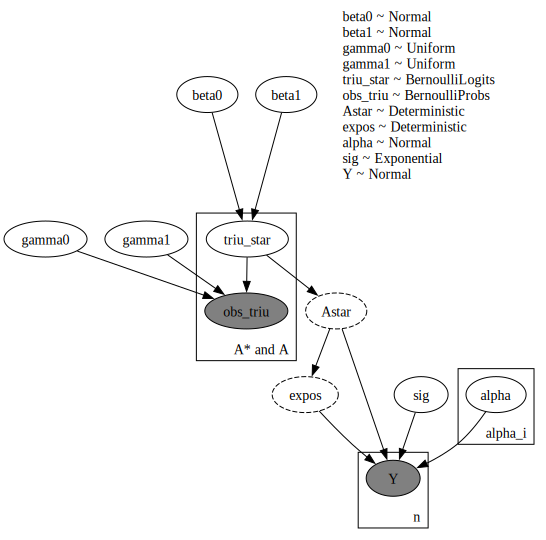

In [342]:
numpyro.render_model(model_discrete, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)


In [343]:
# # Sample from relaxed model
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# # kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model_relaxed)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc.print_summary()
# samples = mcmc.get_samples()
# print(time.time() - start)

In [344]:
print("beta 0:", beta[0], "beta1:", beta[1], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)


beta 0: -2.5 beta1: -0.5 gamma0: 0.049999999999999996 gamma1: 0.3
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [345]:
# Sample from discrete model with mixedHMC
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.2), num_discrete_updates=tril_dim//6)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=1000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [346]:
# Sample from discrete model with NwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [347]:
# Sample from discrete model with HwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(HMC(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)